In [54]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scipy.stats as stats
import scikitplot as skplt
import joblib
import os
from yellowbrick.model_selection import FeatureImportances
%matplotlib inline

In [56]:
cc_data_full_data = pd.read_csv('application_record.csv')
credit_status = pd.read_csv('credit_record.csv')

In [57]:
#1.2 creating the target variable
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
warnings.simplefilter(action='always', category=SettingWithCopyWarning)

In [58]:
# rename the features to a more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [59]:
#split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [60]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)


In [61]:
cc_train_original.shape


(29165, 20)

In [62]:
cc_test_original.shape


(7292, 20)

In [63]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [64]:
cc_data_full_data.head()


,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [65]:
cc_data_full_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [66]:
cc_data_full_data.describe()


,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


In [67]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [68]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    if feature == 'Age':
        # change the feature to be express in positive numbers days
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    elif feature == 'Employment length':
        # select only the rows where the rows are negative to ignore whose who have retired or unemployed
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    elif feature ==  'Account age':
        # change the account age to a positive number of months
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
        print('Description:\n{}'.format(df[feature].describe()))
        print('*'*50)
        print('Object type:\n{}'.format(df[feature].dtype))
        print('*'*50)
        value_cnt = value_cnt_norm_cal(df,feature)
        print('Value count:\n{}'.format(value_cnt))

In [69]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    if feature ==  'Dwelling' or 'Education level':
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(10,10))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels=ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else :
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(10,10))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [70]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title' or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [71]:
cc_train_copy.shape


(29165, 20)

In [72]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 1.5 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [73]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [74]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age'], feat_with_months = ['Account age']):
        self.feat_with_days = feat_with_days
        self.feat_with_months = feat_with_months
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)) & (set(self.feat_with_months).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            # convert months to absolute value
            X['Account age'] = np.abs(X['Account age'])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

In [75]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

In [76]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [77]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [78]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

In [79]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

In [80]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Account age', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [81]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # SMOTE function to oversample the minority class to fix the imbalance data
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'].astype('int64'))
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df


In [82]:
#DATA SAMPLING

In [83]:
def full_pipeline(df):
    min_max_scaler_ft = ['Age', 'Income', 'Account age', 'Employment length']

    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('oversample_smote', OversampleSMOTE())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep


In [84]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
cc_train_prep = full_pipeline(cc_train_copy)

In [85]:
cc_train_prep.shape

(41968, 35)

In [86]:
cc_train_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,...,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count,Account age,Is high risk
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.503478,4.0,0.602718,0.427171,2.0,0.283333,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.503478,1.0,0.203417,0.225597,2.0,0.016667,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.625520,4.0,0.394044,0.778683,4.0,0.633333,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.972428,1.0,0.841939,0.280133,1.0,0.183333,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.818665,4.0,0.599130,0.068756,1.0,0.683333,0


In [87]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

In [88]:
cc_data_full_data = pd.read_csv('application_record.csv')
credit_status = pd.read_csv('credit_record.csv')

In [89]:
classifiers = {
    'sgd':SGDClassifier(random_state=42),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
#   'support_vector_machine':SVC(random_state=42,probability=True),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [90]:
def feat_importance_plot(model, model_name):
    if model_name not in ['support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [91]:
def y_prediction_func(model_trn):
    # check if y_train_copy_pred exists, if not create it
    y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
    try:
        y_cc_train_pred_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
        #save the predictions
        joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
        return y_cc_train_pred
    else:
        # if it exist load the predictions
        y_cc_train_pred = joblib.load(y_cc_train_pred_path)
        return y_cc_train_pred

In [92]:
def confusion_matrix_func(model_name):
    fig, ax = plt.subplots(figsize=(8,8))
    #plot confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn),ax=ax, cmap='Blues',values_format='d')
    # remove the grid
    plt.grid(b=None)
    # increase the font size of the x and y labels
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    #give a title to the plot using the model name
    plt.title('Confusion Matrix', fontsize=14)
    #show the plot
    plt.show()
    print('\n')

In [93]:
def roc_curve_func(model_trn,model_name):
    # check if y probabilities file exists, if not create it
    y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
    try:
        y_proba_path.resolve(strict=True)
    except FileNotFoundError:
        y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
        joblib.dump(y_cc_train_proba,y_proba_path)
    else:
        # if path exist load the y probabilities file
        y_cc_train_proba = joblib.load(y_proba_path)
    skplt.metrics.plot_roc_curve(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
    #remove the gride
    plt.grid(b=None)
    plt.show()
    print('\n')

In [94]:
def score_func(model_trn, model_name):
    # check if score file exists, if not create it
    class_report_path = Path('saved_models/{0}/class_report_{0}.sav'.format(model_name))
    try:
        class_report_path.resolve(strict=True)
    except FileNotFoundError:
        # calculate the scores of the model
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn))
        print(class_report)
        # save the scores
        joblib.dump(class_report,class_report_path)
    else:
        # if it exist load the scores
        class_report = joblib.load(class_report_path)
        print(class_report)

In [95]:
def train_model(model,model_name):
    # check if the model file exist and if not create, train and save it
    model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        if model_name == 'sgd':
            # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
            calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
            model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
        else:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
        joblib.dump(model_trn,model_file_path)
        # plot the most and least predictive features
        return model_trn
    else:
        # if path exist load the model
        model_trn = joblib.load(model_file_path)
        # plot the most and least predictive features
        return model_trn

In [96]:
def folder_check():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))






----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.70      0.96      0.81     20984
           1       0.94      0.58      0.72     20984

    accuracy                           0.77     41968
   macro avg       0.82      0.77      0.76     41968
weighted avg       0.82      0.77      0.76     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


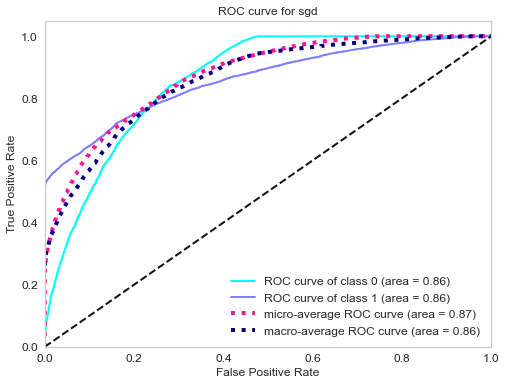

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


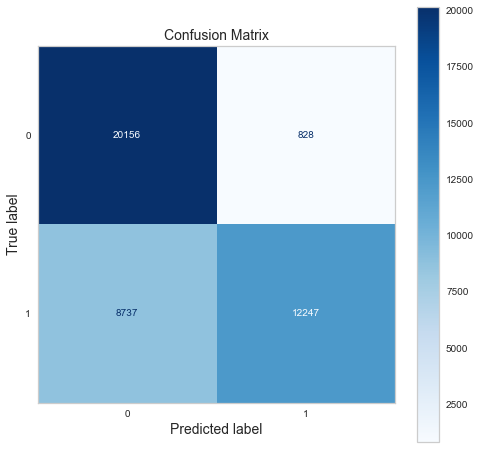

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


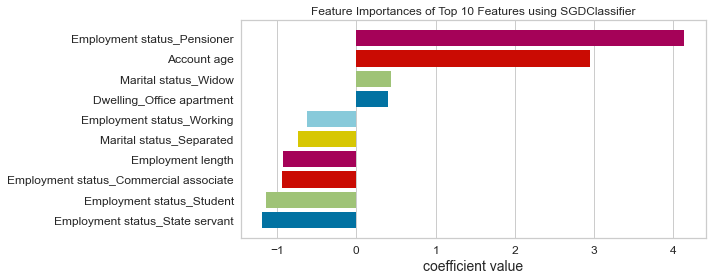

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


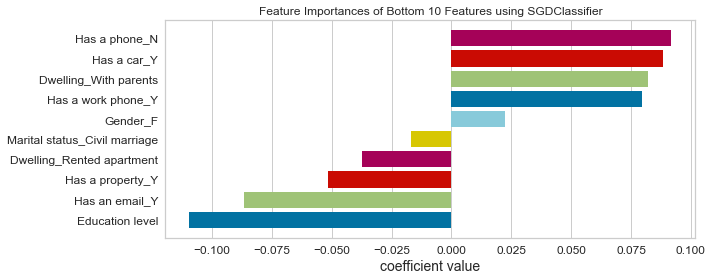







----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     20984
           1       0.64      0.65      0.64     20984

    accuracy                           0.64     41968
   macro avg       0.64      0.64      0.64     41968
weighted avg       0.64      0.64      0.64     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


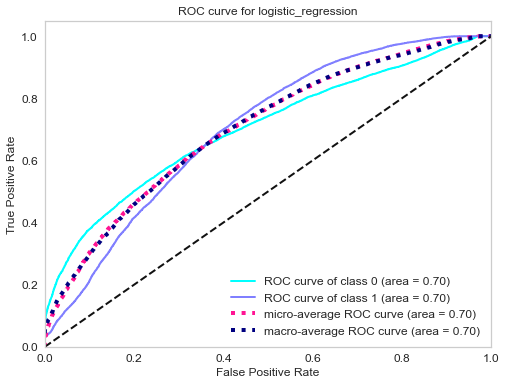

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


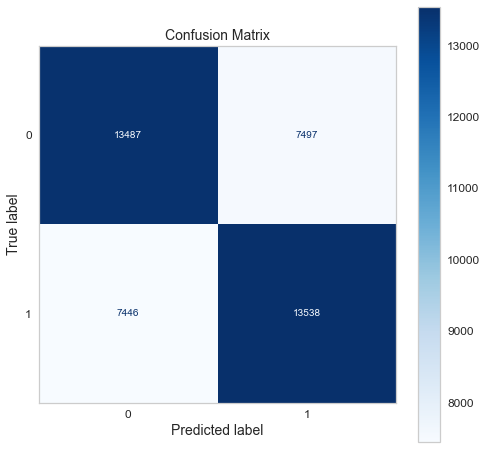

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


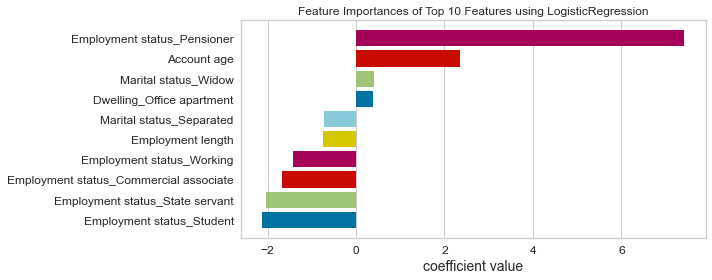

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


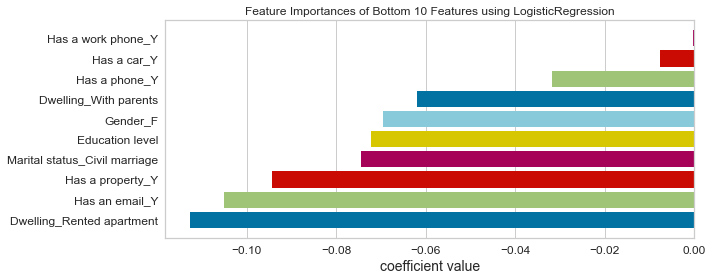







----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.63      0.64      0.63     20984
           1       0.63      0.63      0.63     20984

    accuracy                           0.63     41968
   macro avg       0.63      0.63      0.63     41968
weighted avg       0.63      0.63      0.63     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


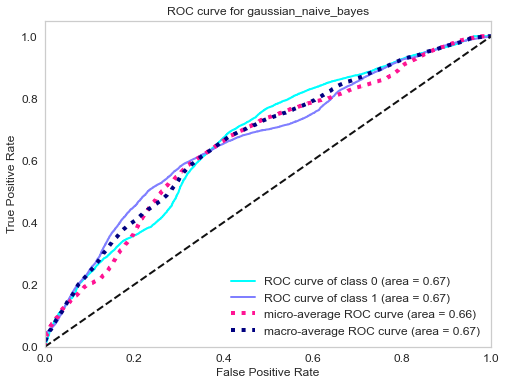

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


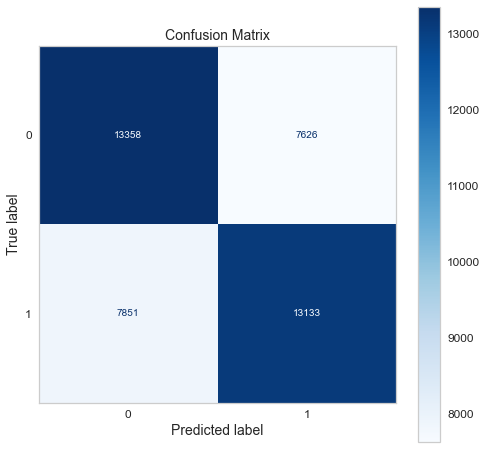



No feature importance for gaussian_naive_bayes






----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     20984
           1       0.95      1.00      0.97     20984

    accuracy                           0.97     41968
   macro avg       0.98      0.97      0.97     41968
weighted avg       0.98      0.97      0.97     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


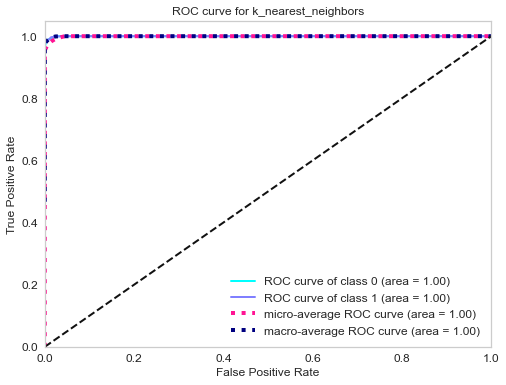

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


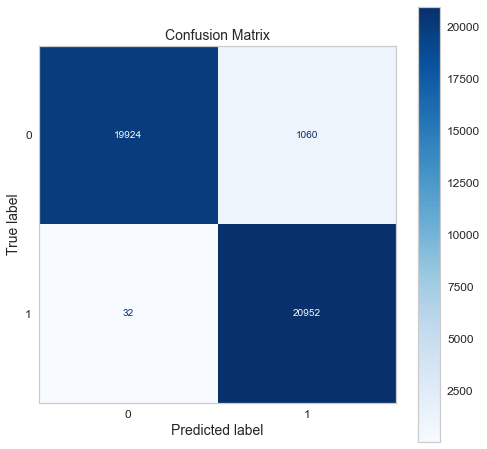



No feature importance for k_nearest_neighbors






----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.92      0.88      0.90     20984
           1       0.88      0.93      0.90     20984

    accuracy                           0.90     41968
   macro avg       0.90      0.90      0.90     41968
weighted avg       0.90      0.90      0.90     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


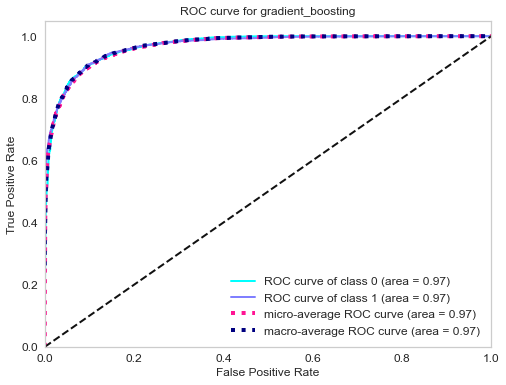

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


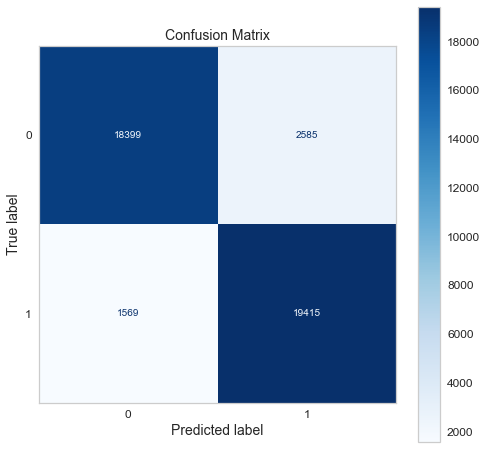

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


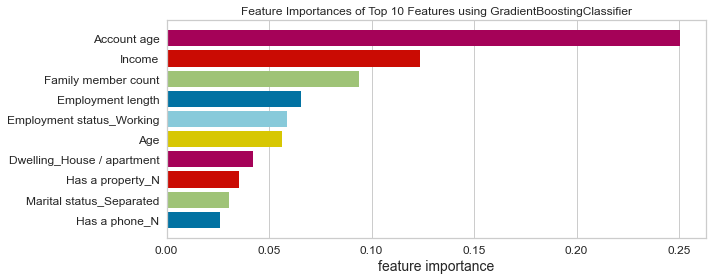

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


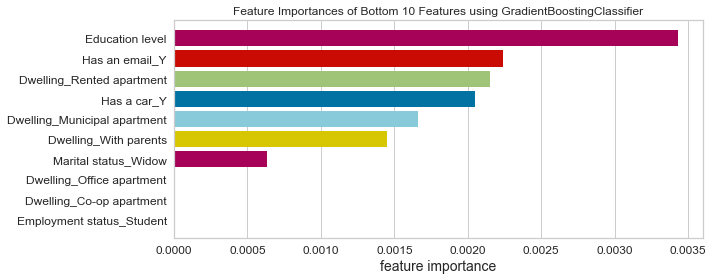







----------------------  linear_discriminant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.64      0.64      0.64     20984
           1       0.64      0.65      0.65     20984

    accuracy                           0.64     41968
   macro avg       0.64      0.64      0.64     41968
weighted avg       0.64      0.64      0.64     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


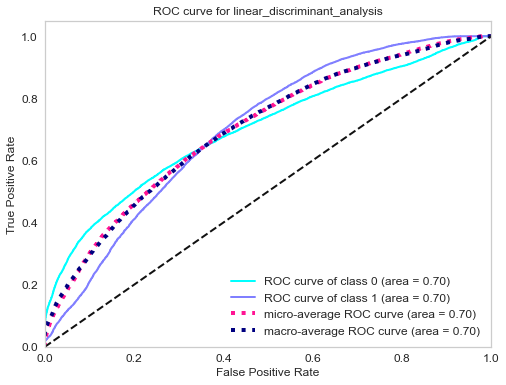

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


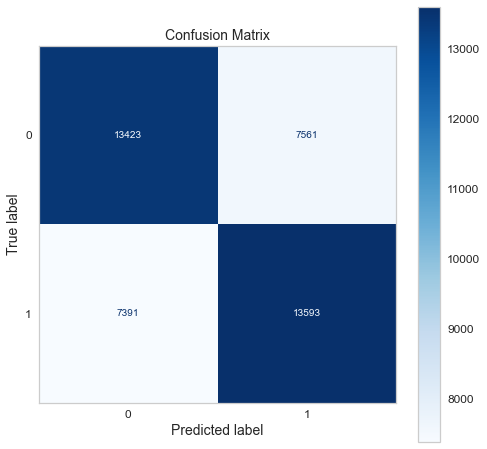

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


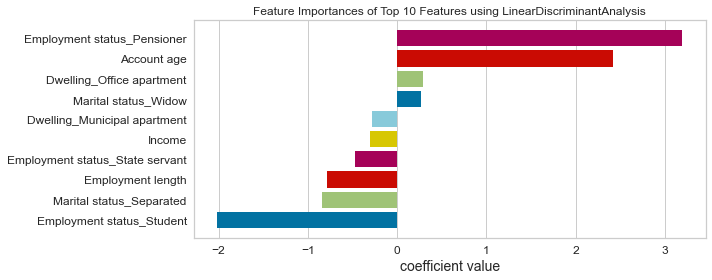

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


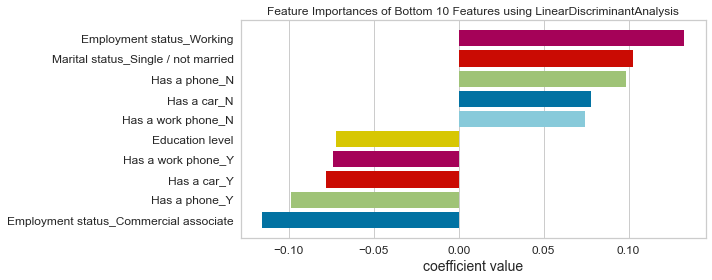







----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20984
           1       0.99      0.99      0.99     20984

    accuracy                           0.99     41968
   macro avg       0.99      0.99      0.99     41968
weighted avg       0.99      0.99      0.99     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


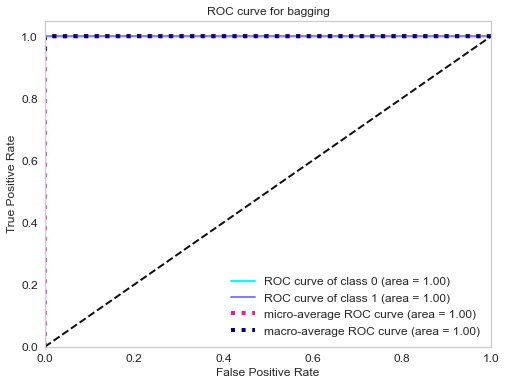

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


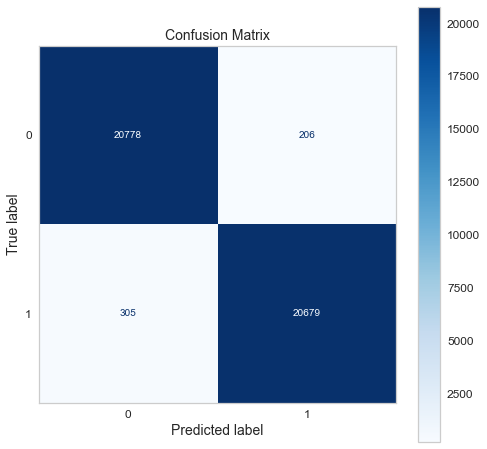



No feature importance for bagging






----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     20984
           1       0.96      0.98      0.97     20984

    accuracy                           0.97     41968
   macro avg       0.97      0.97      0.97     41968
weighted avg       0.97      0.97      0.97     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


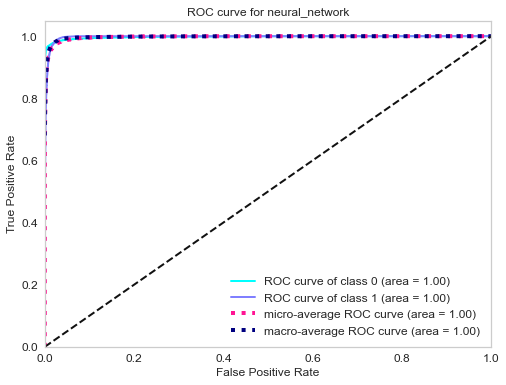

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


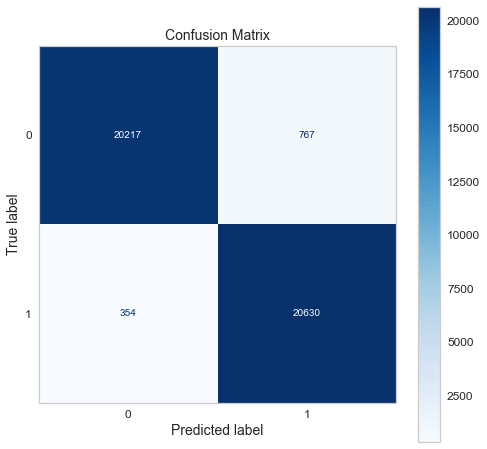



No feature importance for neural_network






----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.81      0.75      0.78     20984
           1       0.77      0.82      0.79     20984

    accuracy                           0.79     41968
   macro avg       0.79      0.79      0.79     41968
weighted avg       0.79      0.79      0.79     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


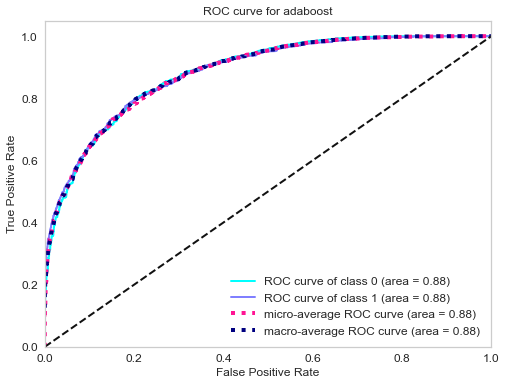

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


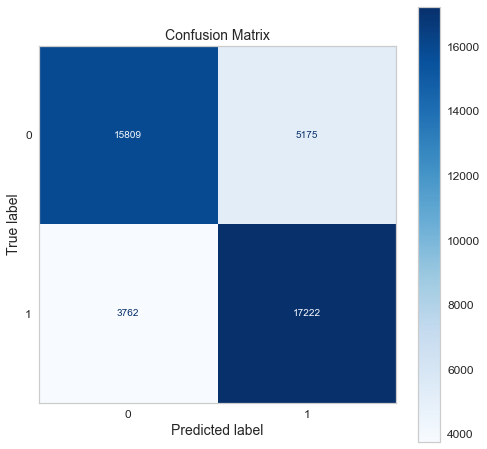

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


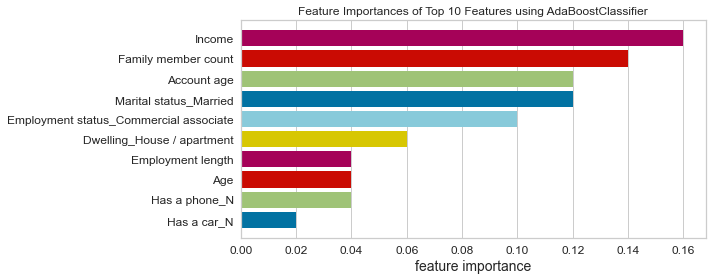

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


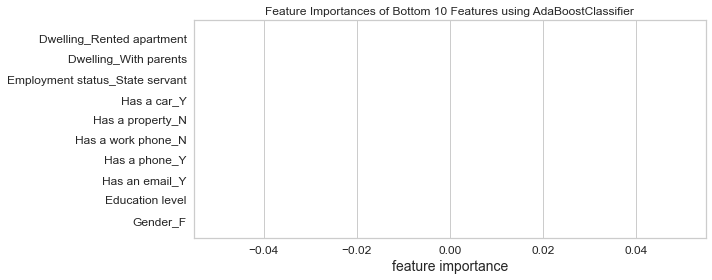







----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20984
           1       0.99      0.99      0.99     20984

    accuracy                           0.99     41968
   macro avg       0.99      0.99      0.99     41968
weighted avg       0.99      0.99      0.99     41968



/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


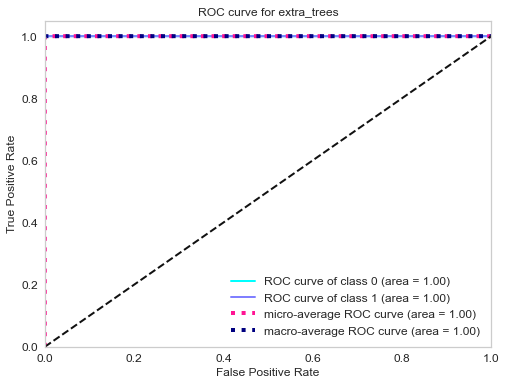

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


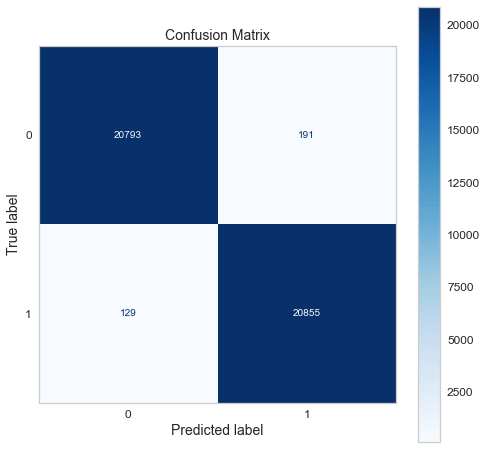

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"


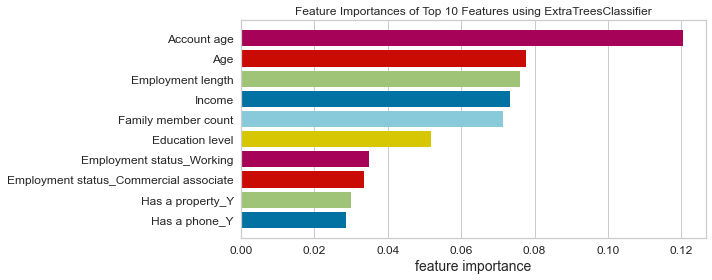

/Users/denaec/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"


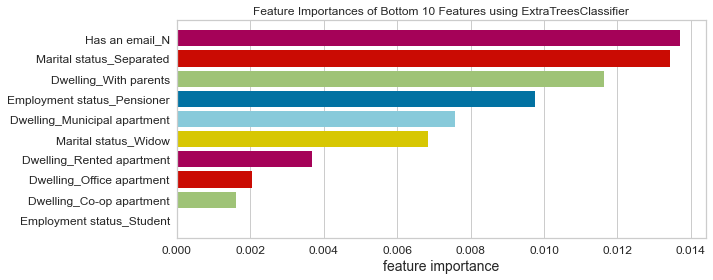

In [97]:
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_name)
    # print the most and least predictive features
    feat_importance_plot(model,model_name)